# Cheat Sheet 4

## Exercise 1
In this exercise, you are tasked with implementing a 2-dimensional gradient descent algorithm where the loss function is not explicitly known Our loss function is a black box to us-- we are allowed to hand it some inputs as parameters to an API call, and it sends us back an output, but we are not privy to its internal mechanisms, so we cannot explictly take its gradient.

Let us briefly review gradient descent on a conceptual level. Here is the gist of a 2-d gradient descent algorithm,
1. Specify an initial set of input parameters: 
    - e.g. $(a,b) = (0.5, 0.5)$
2. Caclulate the gradient (i.e. direction of steepest ascent) of the loss function at those input parameters
    - Find the value of $\nabla f(a,b)$
3. Move (a,b) a small step in the opposite direction of the gradient, since this is the direction of steepest descent
    - Replace $(a,b)$ with $(a,b) - \varepsilon \nabla f(a,b)$ for some small positive scalar $\varepsilon$
4. Rinse and repeat steps 2 & 3 until $f(a,b)$ converges.

![Gradient Descent](Gradient_descent.png)
[image source](https://en.wikipedia.org/wiki/Gradient_descent#/media/File:Gradient_descent.svg)

The only added difficulty we face is in step 2. We need to somehow approximate the gradient based on function values alone. A bit of math should be able to help us in this endeavor. Recall the following formula for the gradient:

$\nabla f(a,b) = \frac{\partial f}{\partial x} (a,b) \hat i + \frac{\partial f}{\partial y} (a,b) \hat j$, where $\hat i$ and $\hat j$ are the unit vectors in the positive $x$ and $y$ directions respectively. 

This formula tells us that the partial derivatives $\frac{\partial f}{\partial x} (a,b)$ and $\frac{\partial f}{\partial x} (a,b)$ in the x and y directions uniquely determine the direction of steepest ascent. These partial derivatives can be computed as follows:

$\frac{\partial f}{\partial x} (a,b) := \lim_{h\to 0} \frac{f(a+h,b) - f(a,b)}{h}$

$\frac{\partial f}{\partial y} (a,b) := \lim_{h\to 0} \frac{f(a,b+h) - f(a,b)}{h}$

Let us focus on the first definition, as the second one follows essentially the same logic.

The numerator of the fraction inside the limit, $f(a+h,b) - f(a,b)$, tells us how much the function $f$ increases or decreases when our input makes small step of size $h$ to the right (in the positive $x$ direction) from our input $(a,b)$. In other words, this is the **rise** as we take a step to the right.

The denominator of that same fraction $h$ is simply the size of the step our input has taken. In other words, this is the **run** of that step to the right. 

As we all learned in basic algebra, slope = rise/run. So the fraction inside the limit is the slope of that small step. As $h\to 0$, our step gets smaller and smaller, so the fraction becomes a better and better approximation of the slope in the $x$ direction at the point $(a,b)$. 

Thus, if we take a suffiently small value of $h$, we get the following approximation:

$\frac{\partial f}{\partial x} (a,b) \approx \frac{f(a+h,b) - f(a,b)}{h}$

By the same reasoning, for a sufficiently small value of $h$, we also get an approximation for the partial derivative in the $y$ direction 

$\frac{\partial f}{\partial y} (a,b) \approx \frac{f(a,b+h) - f(a,b)}{h}$.

Notice that both of these approximations only require us to know a few function values, which we can easily query from the API. Thus we can at last get an approximation of the gradient:

$\nabla f(a,b) \approx \frac{f(a+h,b) - f(a,b)}{h} \hat i + \frac{f(a,b+h) - f(a,b)}{h} \hat j$, for a small value of $h$.

## Exercise 2

In this exercise, we are tasked with modifying Professor McDougal's implementation of the k-means clustering algorithm to work on geographical data (coordinates on a sphere, rather than a plane). Let's start by reviewing his original code to make sense of what's happening at each step.

First, the we import the external tools that we need:

In [6]:
import pandas as pd
import plotnine as p9
import random
import numpy as np

Then we get some data to run our algorithm on and load it into a dataframe:

In [6]:
df = pd.read_csv('https://gist.githubusercontent.com/netj/8836201/raw/iris.csv')

The k-means algorithm works much better if the data is not stretched out in any particular direction, so we write a normalizing function:

In [7]:
def normalize(series):
    return (series - series.mean()) / series.std()

This function moves the series so that it is centered at 0, then scales each value in the series so that its standard deviation is 1.
Using this function, we normalize two series from our dataframe:

In [8]:
df['petal.length.normalized'] = normalize(df['petal.length'])
df['petal.width.normalized'] = normalize(df['petal.width'])

Since we have normalized both of these series, we have effectively centered our dataset at the origin, then squished/stretched it so that it has unit standard deviation both horizontally and vertically.

Our final step in preparation is to specify the inputs and parameters of our algorithm:

In [9]:
k = 3
pts = [np.array(pt) for pt in zip(df['petal.length.normalized'], df['petal.width.normalized'])]

Here, the parameter `k=3` is the number of clusters we have (arbitrarily) chosen to categorize our data into, and the input `pts` is a list of numpy arrays encoding the coordinates for each point.

Now our algorithm begins in earnest. We start by initializing our clusters to have random centers and to contain no points:

In [11]:
centers = random.sample(pts, k)
old_cluster_ids, cluster_ids = None, [] # arbitrary but different

In each run through the following loop, we will iteratively update these clusters by changing the location of their centers. The points will then be reclassified to whichever cluster has the closest center. The algorithm terminates when all the points fail to move between clusters in a single run through the loop:

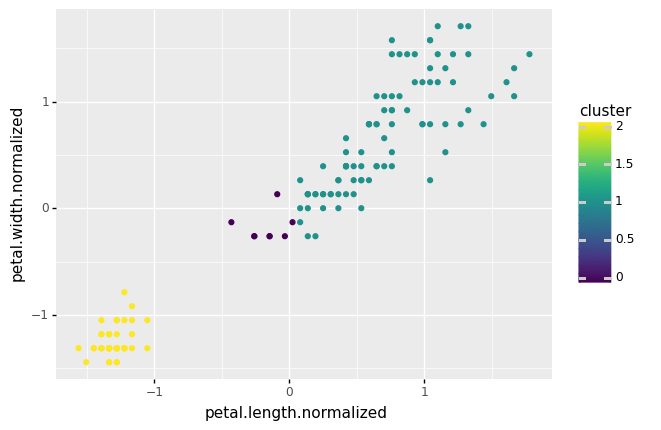

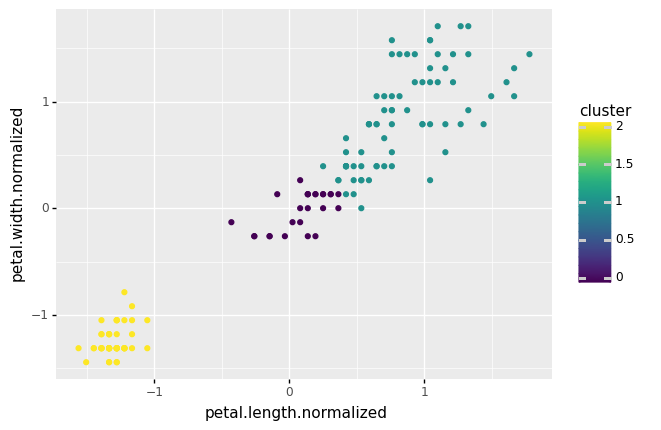

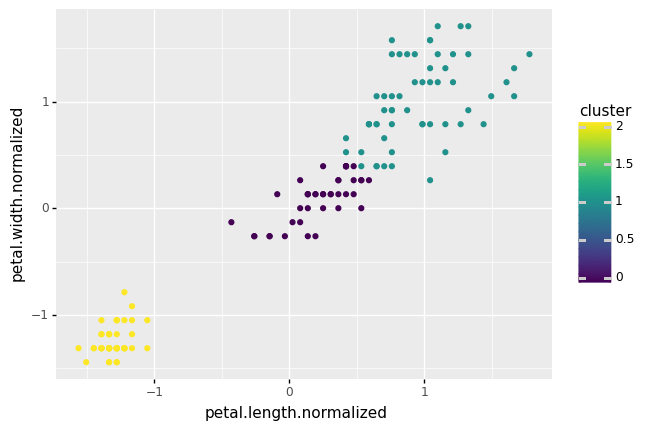

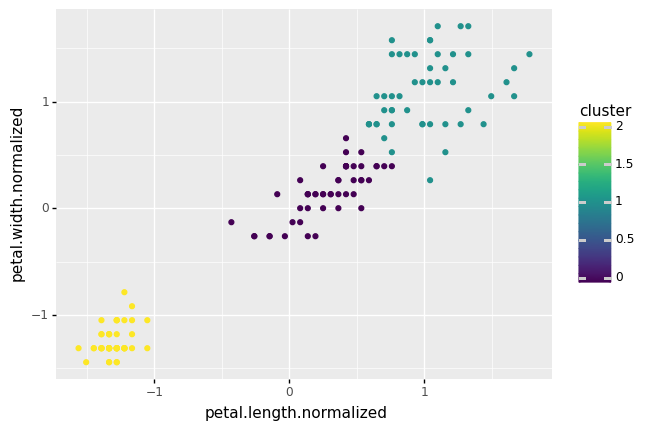

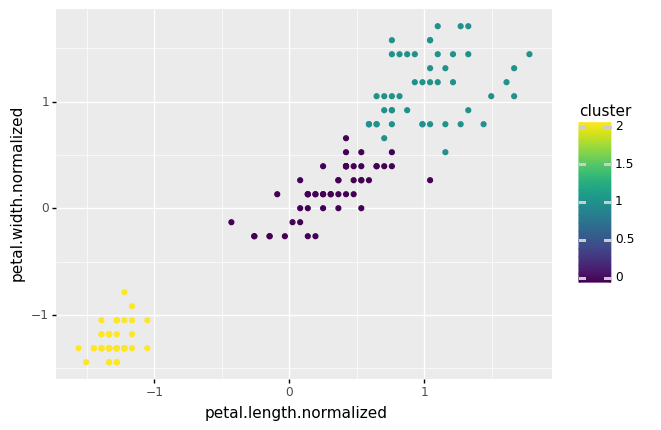

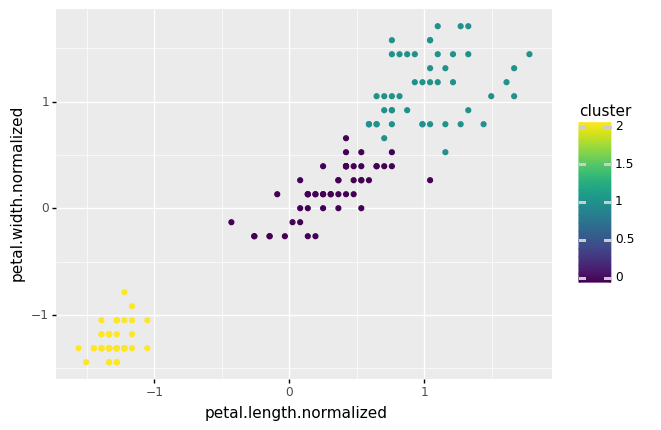

In [11]:
while cluster_ids != old_cluster_ids:
    old_cluster_ids = list(cluster_ids)
    cluster_ids = []
    for pt in pts:
        min_cluster = -1
        min_dist = float('inf')
        for i, center in enumerate(centers):
            dist = np.linalg.norm(pt - center)
            if dist < min_dist:
                min_cluster = i
                min_dist = dist
        cluster_ids.append(min_cluster)
    df['cluster'] = cluster_ids
    cluster_pts = [[pt for pt, cluster in zip(pts, cluster_ids) if cluster == match]
                    for match in range(k)]
    centers = [sum(pts)/len(pts) for pts in cluster_pts]
    (p9.ggplot(df, p9.aes(x="petal.length.normalized", y="petal.width.normalized", color="cluster")) + p9.geom_point()).draw()

Pay special attention to the following block of code:

```python
for i, center in enumerate(centers):
            dist = np.linalg.norm(pt - center)
            if dist < min_dist:
                min_cluster = i
                min_dist = dist
        cluster_ids.append(min_cluster)
```

In the second line, we are using the euclidian norm of $pt - center$ to determine the distance between that point and that cluster's center. It is precisely this distance function that determines which cluster's center is closest, and therefore which cluster the point will end up in the next run through the loop. This works perfectly well when our points are in euclidian space, as is the case with the above dataset. If, however, our points are in some other type of space, like a sphere (*wink wink*), we need to use a different metric to determine the distance between a given point and a given cluster center.

Also pay attention to the following line of code from the algorithm:

```python
centers = [sum(pts)/len(pts) for pts in cluster_pts]
```

This line adjusts the center of each cluster to actually be at the center of mass (or more formally, the centroid) of all that cluster's points. Again, this is applicable in euclidian space, but fails to apply for other types of spaces. To illustrate this, suppose we have 2 points, A & B, on the equator, one at longitude 160, and one at longitude -160. We would intuitively expect that the "center" between these points will be the midpoint on the shortest between A & B arc $\widehat{AB}$, but the euclidean centroid will give us the point at $(lat,long)=(0,0)$

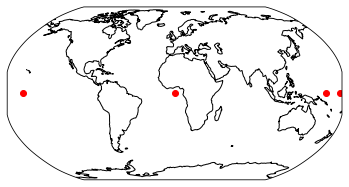

In [16]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())
A = [0, -160]
B = [0, 160]
C = [0, 175] #should be [0, 180], but plot cuts off at edges
D = [0, 0]
lats = [coords[0] for coords in [A, B, C, D]]
lngs = [coords[1] for coords in [A, B, C, D]]
ax.coastlines()
ax.plot(lngs, lats, "o", color="red", transform=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
plt.show()

In [3]:
#install cartopy in terminal
!conda install -c conda-forge cartopy -y

Solving environment: - 
  - anaconda/linux-64::certifi-2021.10.8-py39h06a4308_0
  - defaults/linux-64::certifi-2021.10.8-py39h06a4308done

## Package Plan ##

  environment location: /home/mw598/anaconda3

  added / updated specs:
    - cartopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    cartopy-0.18.0             |   py39h0d9ca2b_1         1.7 MB
    conda-4.13.0               |   py39hf3d152e_1         998 KB  conda-forge
    geos-3.8.0                 |       he6710b0_0         961 KB
    proj-6.2.1                 |       hc80f0dc_0        10.2 MB  conda-forge
    pyshp-2.3.0                |     pyhd8ed1ab_0         862 KB  conda-forge
    shapely-1.7.1              |   py39h1728cc4_0         397 KB
    ------------------------------------------------------------
                                           Total:        15.0 MB

The following NEW packages will be INSTALLED:

  

In [5]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r

/home/mw598/anaconda3/lib/python3.9/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/110m/physical/ne_110m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


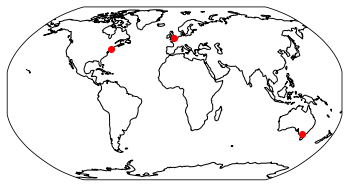

In [4]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())
yale = [41.3083, -72.9279]
oxford = [51.7520, -1.2577]
melbourne = [-37.8136, 144.9631]
lats = [school[0] for school in [yale, oxford, melbourne]]
lngs = [school[1] for school in [yale, oxford, melbourne]]
ax.coastlines()
ax.plot(lngs, lats, "o", color="red", transform=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
plt.show()

## Exercise 3

This exercise is relatively straightforward. 
Just remember to cache all the values that you have computed towards the end of each function call, and only explictly calculate a value from using recursion if that value is not already in the cache.

## Exercise 4